
# Détection de faux billets 💵
L’Organisation nationale de lutte contre le faux-monnayage, ou ONCFM,
est une organisation publique ayant pour objectif de mettre en place des
méthodes d’identification des contrefaçons des billets en euros. Dans le
cadre de cette lutte, nous souhaitons mettre en place un algorithme qui
soit capable de différencier automatiquement les vrais des faux billets.

Parmi les outils de lutte contre le faux monnayage, le machine learning peut permettre de détecter ces fraudes, en s'appuyant sur des caractères quantitatifs comme les mesures des billets.

Nous créerons ici un algorithme de détection des faux billets, en partant d'un jeu de données contenant les caractéristiques géométriques de vraies et fausses coupures.




In [1190]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [1191]:
warnings.filterwarnings('ignore')
sns.set(rc={"figure.dpi":100, 'savefig.dpi':100})
sns.set_context('notebook')
sns.set_style("ticks")

# Analyse

## Présentation des données

Le fichier **billtest.csv** liste les caractéristiques de **1500** billets de banque différents. On dispose de l'authenticité de chaque billet (True ou False), et de 6 mesures toutes exprimées en millimètres : diagonale, hauteurs à gauche et à droite, marges hautes et basses, longueur.

In [1192]:
df=pd.read_csv("billets.csv",sep=';')
df

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25


In [1193]:
print(len(df)-len(df.drop_duplicates()),'doublons') # Aucun doublons 

0 doublons


In [1194]:
df.info() # 37 données nulles sur la colonne margin_low

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


## Données manquantes

On peut s'appuyer sur une regression linéaire pour modeliser les valeurs manquantes de la colonne **margin_low**. Cette colonne sera considérée comme la variable réponse et le reste des colonnes comme des variables explicatives.

In [1195]:
df_nan=df.copy()
# on supprime la colonne is_genuine
df_nan.pop("is_genuine") 
# dataframe avec la colonne margin_low null
df_nodrop=df_nan[df_nan['margin_low'].isna()] 
# dataframe avec la colonne margin_low NO null
df_dropnan=df_nan[~df_nan['margin_low'].isna()] 
df_dropnan.head()

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.81,104.86,104.95,4.52,2.89,112.83
1,171.46,103.36,103.66,3.77,2.99,113.09
2,172.69,104.48,103.50,4.40,2.94,113.16
3,171.36,103.91,103.94,3.62,3.01,113.51
4,171.73,104.28,103.46,4.04,3.48,112.54


In [1196]:
df_dropnan.shape

(1463, 6)

In [1197]:
df_dropnan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1463 entries, 0 to 1499
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   diagonal      1463 non-null   float64
 1   height_left   1463 non-null   float64
 2   height_right  1463 non-null   float64
 3   margin_low    1463 non-null   float64
 4   margin_up     1463 non-null   float64
 5   length        1463 non-null   float64
dtypes: float64(6)
memory usage: 80.0 KB


In [1198]:
df_nodrop.shape

(37, 6)

In [1199]:
df_nodrop.head()

,diagonal,height_left,height_right,margin_low,margin_up,length
72,171.94,103.89,103.45,NaN,3.25,112.79
99,171.93,104.07,104.18,NaN,3.14,113.08
151,172.07,103.80,104.38,NaN,3.02,112.93
197,171.45,103.66,103.80,NaN,3.62,113.27
241,171.83,104.14,104.06,NaN,3.02,112.36


In [1200]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

regression=LinearRegression()

# affecte la variable reponse "margin_low" à y
y=df_dropnan.pop("margin_low")

# stat model pour afficher r2,p-value 
myreg = sm.OLS(y, sm.add_constant(df_dropnan)).fit()
print(myreg.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Fri, 27 May 2022   Prob (F-statistic):          2.60e-202
Time:                        11:47:50   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           22.9948      9.656      2.382   

In [1201]:
#supprime la variable reponse dans nodrop
df_nodrop.pop("margin_low")
df_nodrop.head()

,diagonal,height_left,height_right,margin_up,length
72,171.94,103.89,103.45,3.25,112.79
99,171.93,104.07,104.18,3.14,113.08
151,172.07,103.80,104.38,3.02,112.93
197,171.45,103.66,103.80,3.62,113.27
241,171.83,104.14,104.06,3.02,112.36


### Normalité des residus 

In [1202]:
from math import sqrt
residues = myreg.resid_pearson

residues_std = residues/sqrt(sum(residues**2)/(len(residues)-1)) #standardiser


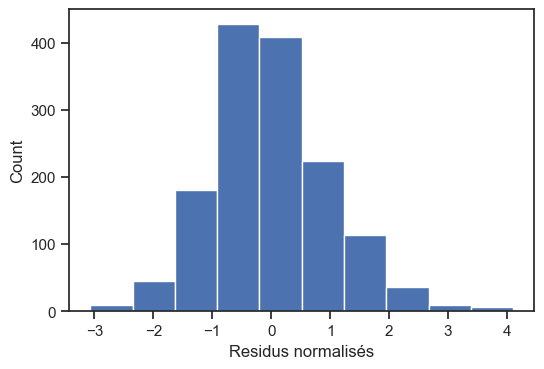

In [1203]:
plt.hist(residues_std)
plt.ylabel('Count')
plt.xlabel('Residus normalisés')

show()

Normalité des résidus (Shapiro)

p-value : 8.538752344078304e-11
H0 rejetée : distribution probablement pas normale


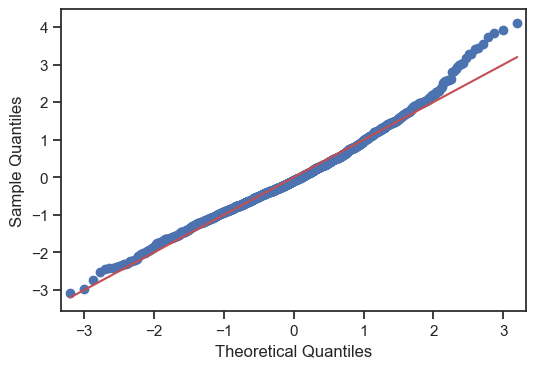

In [1204]:
from statsmodels.graphics.gofplots import qqplot
from scipy import stats
from scipy.stats import shapiro

# Test de Shapiro sur les résidus
p=shapiro(residues_std)[1]
print('Normalité des résidus (Shapiro)')
print('\np-value :', p)
if p>.05:
    print('H0 acceptée : distribution normale')
else:
    print('H0 rejetée : distribution probablement pas normale')
qqplot(residues_std, line='s')
plt.show()

### homoscedasticité

In [1205]:
from statsmodels.stats.api import  het_breuschpagan

lagrande, pval, f, fpval = het_breuschpagan(myreg.resid, myreg.model.exog)
print('Test breusch pagan')
print('\np-value :', pval)
if p>.05:
    print('H0 acceptée : les variannces sont constantes')
else:
    print('H0 rejetée : les variances ne sont pas constantes')


Test breusch pagan

p-value : 7.759535216285984e-16
H0 rejetée : les variances ne sont pas constantes


## Colinéarité

Tous les coefficients sont inferieurs à 10, il n'y pas donc de probléme de colinéarité 

In [1206]:
 from statsmodels.stats.outliers_influence import variance_inflation_factor
[variance_inflation_factor(myreg.model.exog, i) for i in range(1,myreg.model.exog.shape[1])]

[1.0136128990686286,
 1.1382605736082485,
 1.2301145155560416,
 1.4044037781843612,
 1.576950145366583]

## Conclusion validité 

L'hypothése de normalité est remise en cause (p-value < 0,05) .Néanmoins, l'observation  des residus, le fait qu'il ne soit pas très differents d'une distribution symétrique , et le fait que l'echantillon soit de taille suffisante (superieur à 30) permettent de dire que :
#### les résultats obtenus par le model linéaire  ne sont pas absurdes, même si les resisdus ne sont pas considerés comme étant normaux

## Prédiction des données manquantes

In [1207]:
regression.fit(df_dropnan,y)
prediction=regression.predict(df_nodrop.values) 
prediction

array([4.31852466, 4.39366755, 4.41045663, 4.31901423, 4.6506171 ,
       3.80330831, 4.17973608, 4.12744154, 4.13503418, 4.16053851,
       4.17742026, 3.76855378, 4.05876385, 4.29804709, 4.16060746,
       4.09406453, 4.43984627, 4.47065037, 4.34164322, 4.08041448,
       3.61430588, 4.37181147, 4.09362068, 4.24962896, 3.89374829,
       3.74633265, 4.23741481, 4.71053287, 4.13778022, 5.05027715,
       4.80214523, 5.067584  , 5.04756967, 4.77896717, 5.726993  ,
       5.18586214, 5.14004269])

Affichage da la distribution des données prédites

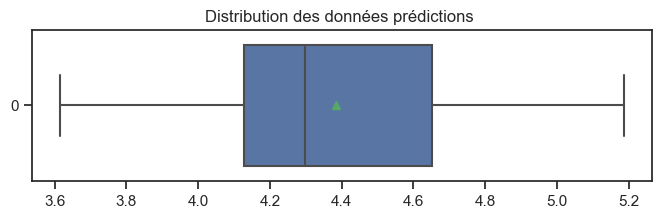

In [1208]:
plt.figure(figsize=(8, 2))

sns.boxplot(data=prediction, orient='h', showfliers=False, showmeans=True)
plt.title('Distribution des données prédictions ')

plt.show()


Les données prédites sont bien dans l'intervalle de données de la colonne **margin_low**

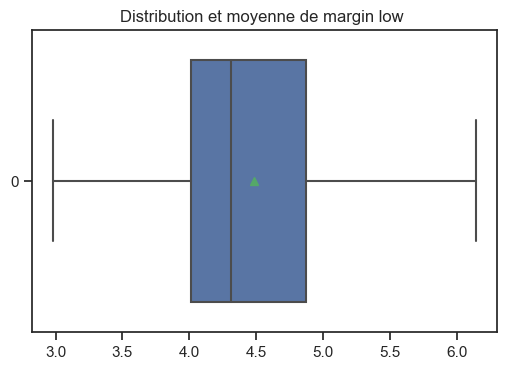

In [1209]:
sns.boxplot(data=df['margin_low'], orient='h', showfliers=False, showmeans=True)
plt.title('Distribution et moyenne de margin low ')
#plt.savefig(url_fig + 'boxplot_predictions-prix.png', dpi=300, bbox_inches='tight')
plt.show()


## Choix sur le remplacement des données manquantes

In [1210]:
# dataframe avec la colonne margin_low null
df_n=df[df['margin_low'].isna()]
#on remplace les données nulles par les prédictions 
df_n["margin_low"]=prediction 
# dataframe avec la colonne margin_low non null
df_nonan=df[~df['margin_low'].isna()]
df_nonan
#df_nonan.shape

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25


In [1211]:
# On fait une concaténation des deux dataframes pour creer le nouveau df
df=pd.concat([df_nonan,df_n]) 
#soit on supprime les données manquante
#df=df.dropna()

In [1212]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 0 to 1438
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 83.5 KB


## Analyse descriptive

On compte 1000 vrais billets et 500 faux billets 

In [1213]:
df['is_genuine'].value_counts()

True     1000
False     500
Name: is_genuine, dtype: int64

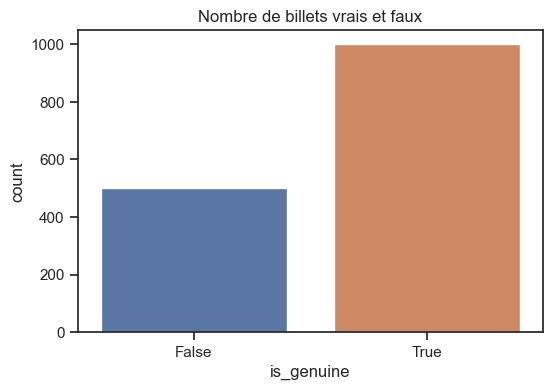

In [1214]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='is_genuine')
plt.title('Nombre de billets vrais et faux')
plt.show()

## Analyse des corrélations 

sns.pairplot trace l'histogramme de chaque variable quantitative, pour chaque classe de la variable catégorielle is_genuine.

La longueur et la marge basse permettent le mieux de discriminer les vrais billets des faux.

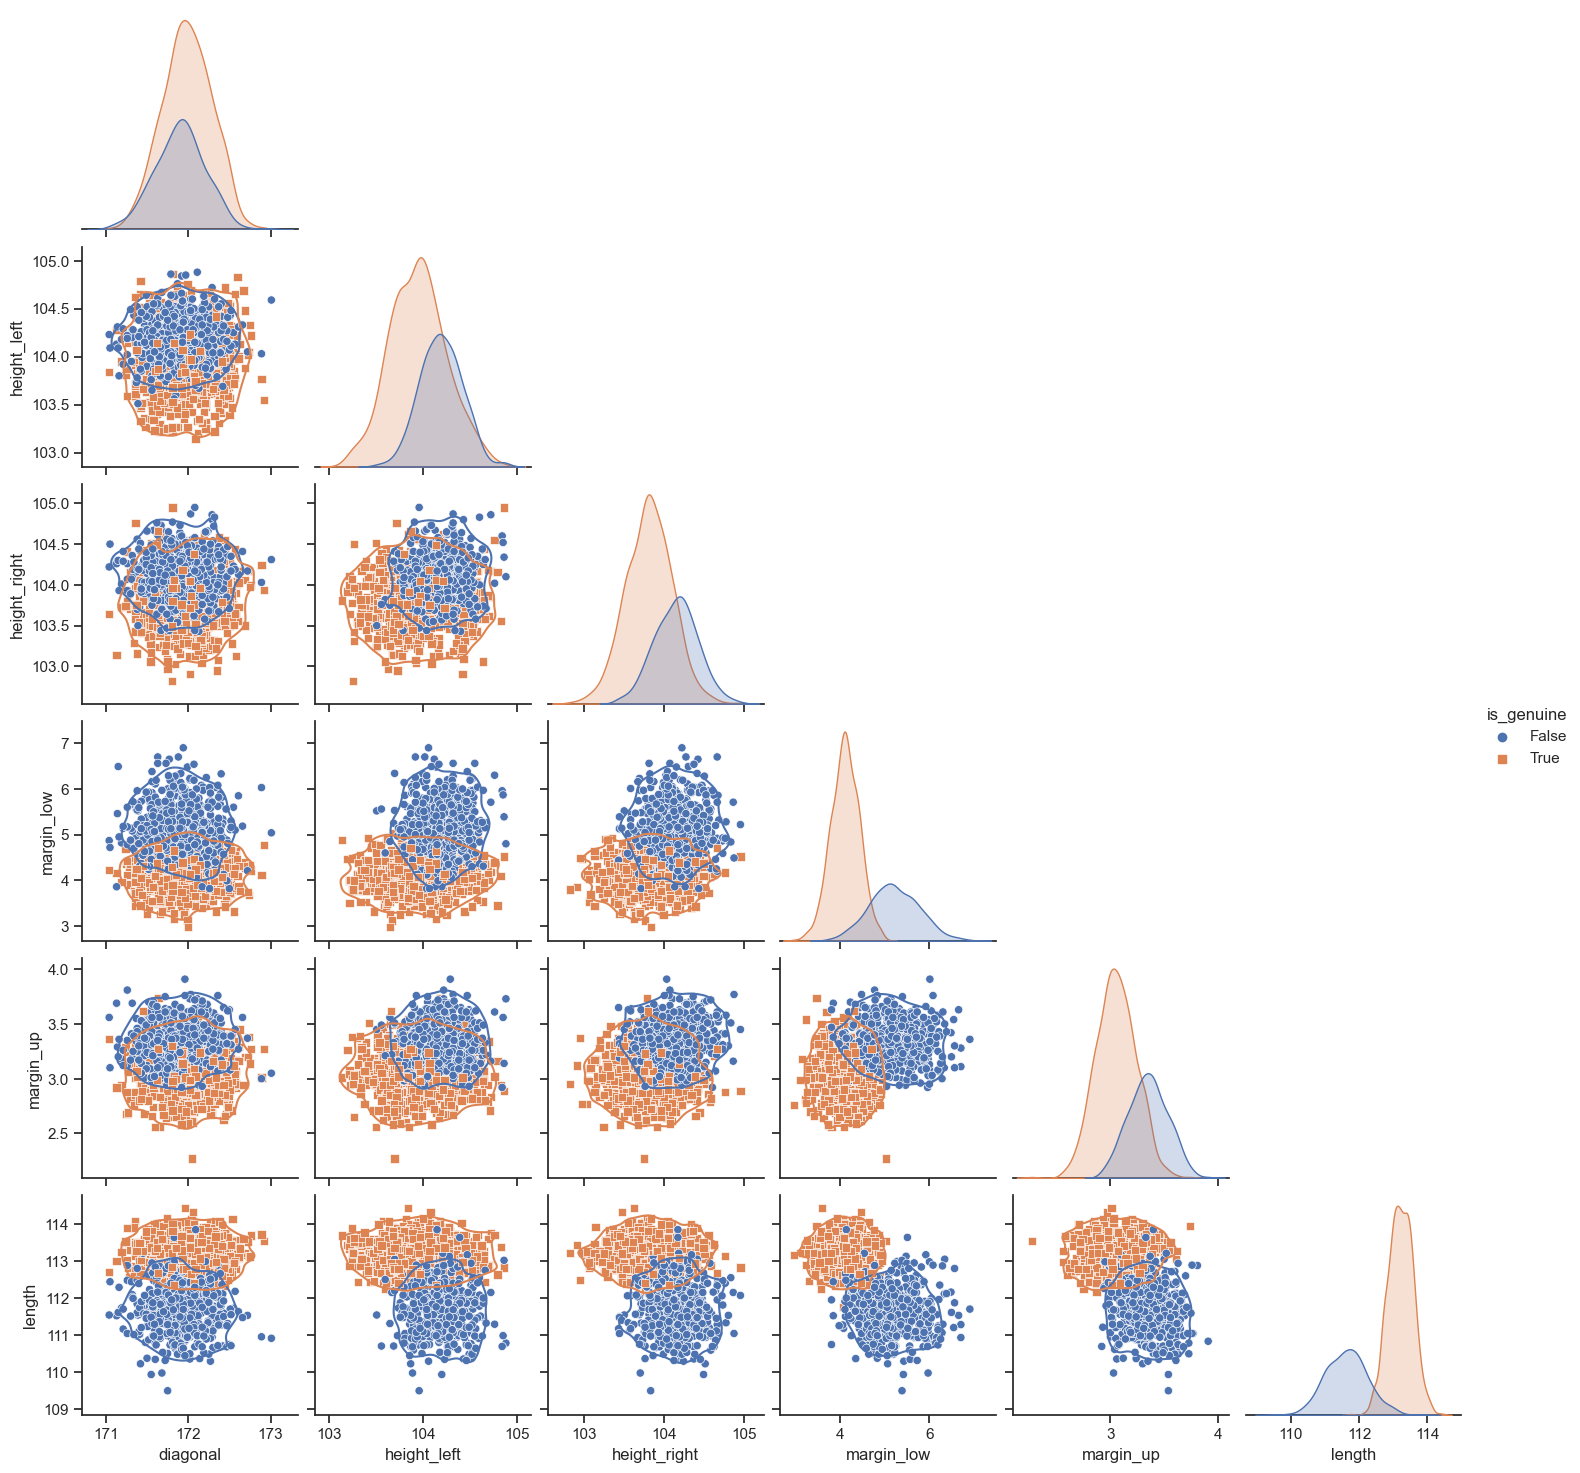

In [1215]:
g = sns.pairplot(df, hue='is_genuine', markers=['o','s'], corner=True)
g.map_lower(sns.kdeplot, levels=2, color='.2')
plt.show()

Les faux billets sont plus courts que les vrais, et leur marge basse est à l'inverse nettement plus longue.

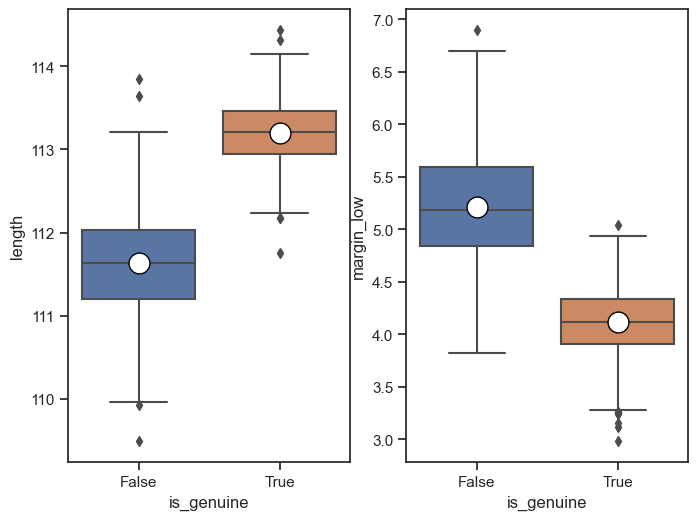

In [1216]:
fig, ax = plt.subplots(1,2, figsize=(8,6))
meanprops = {"marker":"o","markerfacecolor":"white", "markeredgecolor":"black", "markersize":"15"}
sns.boxplot(data=df, y='length', x='is_genuine', showmeans=True, meanprops=meanprops, ax=ax[0])
sns.boxplot(data=df, y='margin_low', x='is_genuine', showmeans=True, meanprops=meanprops, ax=ax[1])
plt.show()

La matrice des corrélations résume les dépendances entre variables par une valeur entre -1 et 1 :
- `0` : absence de corrélation
- `1` : corrélation positive
- `-1` : corrélation négative

Elle confirme l'impact de la longueur et de la marge basse sur l'authenticité. On dit donc que la véracité du billet est corrélée positivement à la longueur, et négativement à la marge basse.

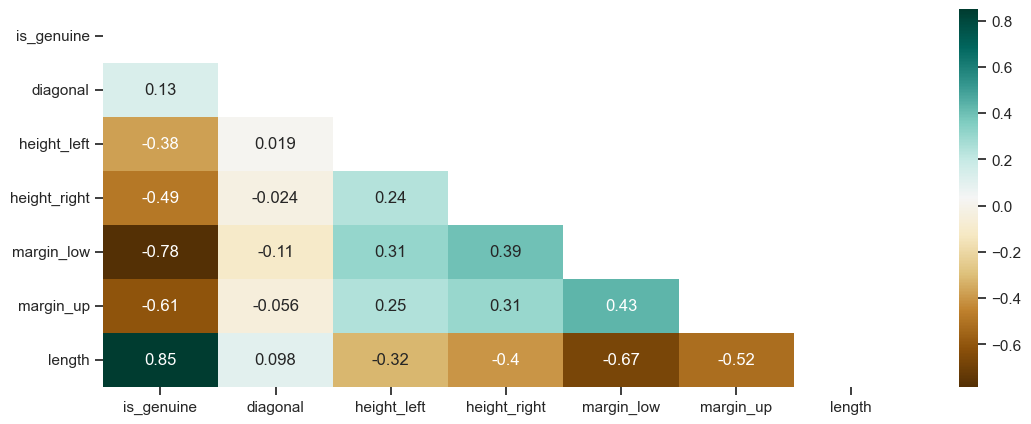

In [1217]:
# Calculate pairwise-correlation
matrix = df.corr()

# Triangle de corrélations
mask = np.triu(np.ones_like(matrix))
plt.figure(figsize=(13, 5))
sns.heatmap(matrix, mask=mask, annot=True, cmap='BrBG')
plt.show()

# ACP

L'analyse en composantes principales va nous permettre de réduire nos 6 variables quantitatives à 2. On pourra alors représenter chaque billet dans un espace à 2 dimensions. Ce qui permettra de vérifier où se situent les vrais et faux billets dans l'espace, et s'ils forment des clusters distincts. L'ACP étant sensible à la variance, on va d'abord standardiser les variables quantitatives.

## Standardisation des variables

Même si toutes les variables s'expriment en millimètres, leur échelle varie. Ici les marges avoisinnent 4mm alors que les longueurs dépassent 170mm. Pour que les valeurs comme celles de la longueur n'aient pas trop de poids face aux autres, il faut que toutes nos variables s'expriment dans la même unité.



[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed on the [6] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


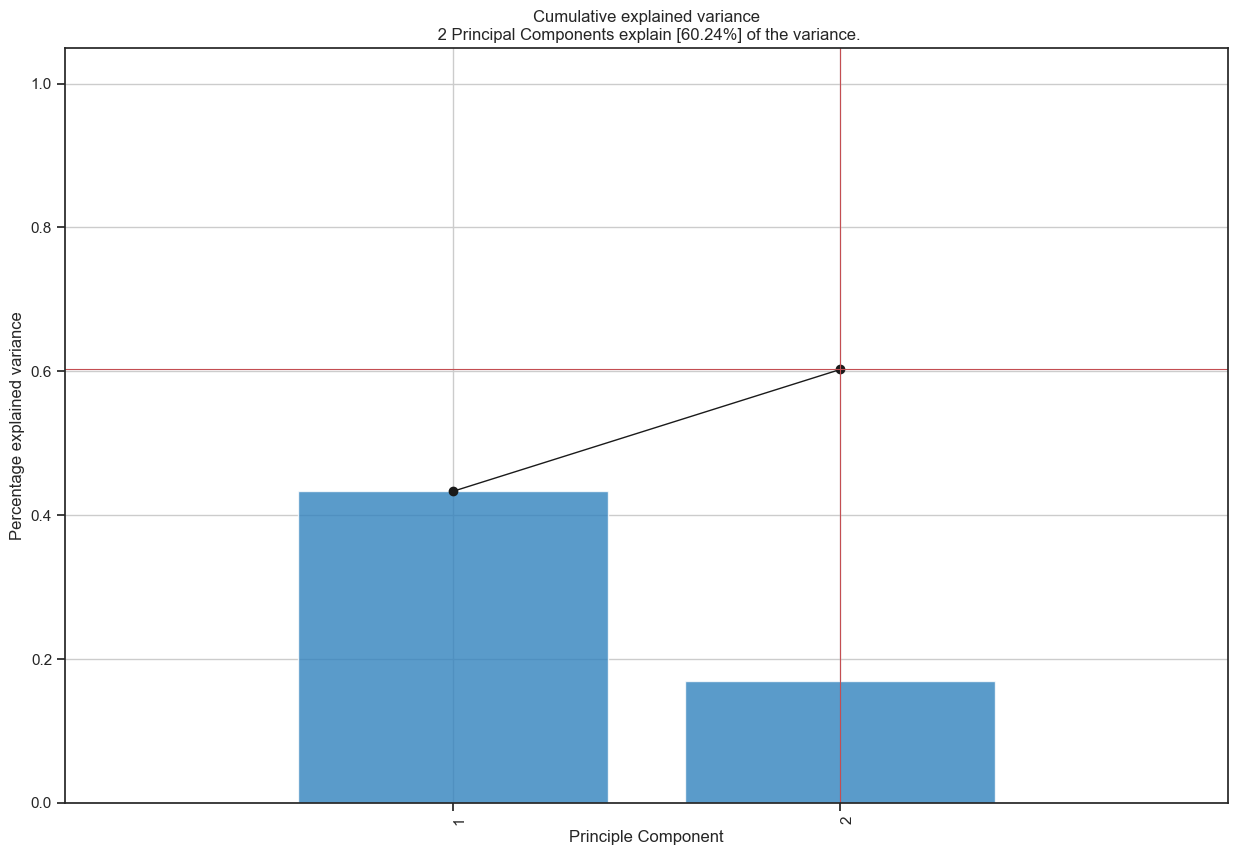

<Figure size 600x400 with 0 Axes>

In [1218]:
from sklearn import preprocessing
from pca import pca

# Variables quantitatives à standardiser
X = df.drop(['is_genuine'], axis=1) 
X = preprocessing.StandardScaler().fit_transform(X)
# acp à deux composant
model = pca(n_components=2)
# Fit des valeurs sur le modèle
results = model.fit_transform(X)
fig, ax = model.plot()
plt.show()

In [1219]:
reduce = pd.merge(results['PC'].reset_index(drop=True), df.reset_index(drop=True), left_index=True, right_index=True)


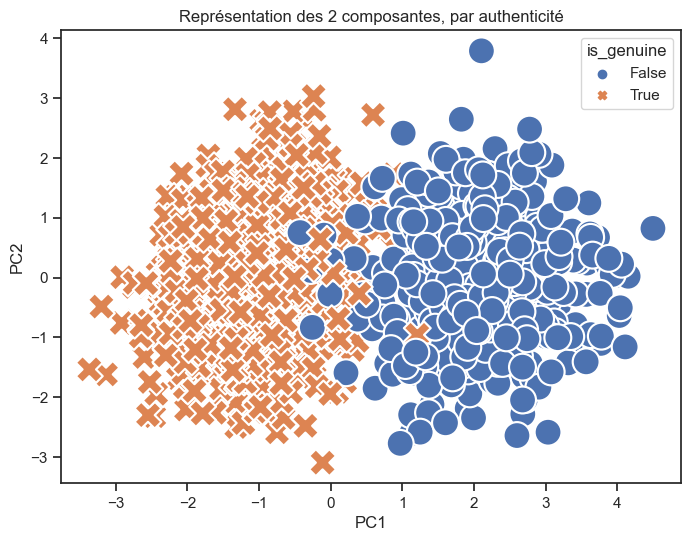

In [1220]:
plt.figure(figsize=(8, 6))
scatter_markers = ['+','o']
sns.scatterplot(data=reduce, x='PC1', y='PC2', style='is_genuine', hue='is_genuine', s=375)
plt.title('Représentation des 2 composantes, par authenticité')
plt.show()

Projetés sur un plan à 2 dimensions, les vrais et faux billets forment bien 2 groupes distincts, qu'on pourrait séparer par une ligne. 

# Clustering : Kmeans

On applique le kmeans pour verifier si les partions des clusters correspondent à la classe "is_geniune".
on voit bien que les faux billets correspondent au cluster 0 et les vrais billets au cluster 1 donc on peut bien appliquer les models de classifications afin d'etudier les vrais et faux billets

In [1221]:
from sklearn.cluster import KMeans
km=KMeans(n_clusters=2, random_state=0).fit(X)
clusters = pd.DataFrame(km.predict(X), columns=['cluster'])
cluster_reduce=pd.merge(reduce,clusters,left_index=True, right_index=True)
cluster_reduce

,PC1,PC2,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,cluster
0,1.644135,0.747843,True,171.81,104.86,104.95,4.520000,2.89,112.83,1
1,-2.019910,-2.207492,True,171.46,103.36,103.66,3.770000,2.99,113.09,0
2,-0.969864,2.620492,True,172.69,104.48,103.50,4.400000,2.94,113.16,0
3,-1.377462,-1.818370,True,171.36,103.91,103.94,3.620000,3.01,113.51,0
4,0.148712,-0.566722,True,171.73,104.28,103.46,4.040000,3.48,112.54,0
...,...,...,...,...,...,...,...,...,...,...
1495,1.157517,0.933306,False,172.17,104.49,103.76,5.047570,2.93,111.21,1
1496,1.334642,0.522467,False,172.08,104.15,104.17,4.778967,3.40,112.29,1
1497,4.040762,-0.505438,False,171.72,104.46,104.12,5.726993,3.61,110.31,1
1498,2.774632,2.482888,False,172.66,104.33,104.41,5.185862,3.56,111.47,1


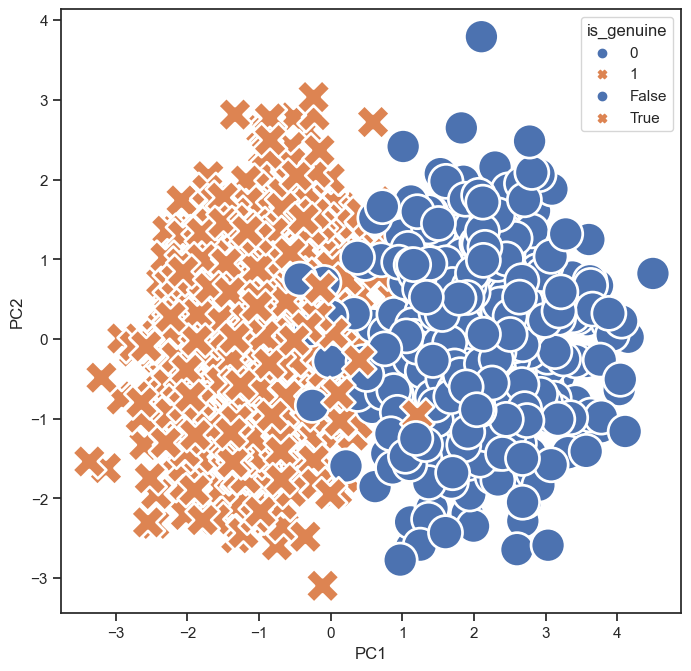

In [1222]:
plt.figure(figsize=(8,8))
sns.scatterplot(data=cluster_reduce, x='PC1', y='PC2', style='cluster', hue='cluster', s=150)
sns.scatterplot(data=cluster_reduce, x='PC1', y='PC2', style='is_genuine', hue='is_genuine', s=600)
plt.show() # Contour = classe réelle ; Point = cluster

# Modélisation du modéle de classification

On va mettre en concurrence deux algorithme de machine learning : 

- `KMeans` 
- `Regression logistique ` 

L'objectif est de choisir le meilleur modéle afin de l'utiliser pour la detection de faux billet en production 

In [1223]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn import metrics

import pickle

## Split

On dissocie is_genuine (qu'on appelle `y` : la variable réponse) des autres variable `X` .

In [1224]:
y = df['is_genuine']
y

0        True
1        True
2        True
3        True
4        True
        ...  
1303    False
1315    False
1347    False
1435    False
1438    False
Name: is_genuine, Length: 1500, dtype: bool

Puis `X`  et `y`  sont divisés en 2 échantillons train et test. Les jeux test représenteront ici un tiers des données.

In [1225]:
X_train, X_test, y_train, y_test = train_test_split(
    df, y, test_size=0.33, random_state=42)

print('X_train :', len(X_train), 'lignes',
    '\ny_train :', len(y_train), 'lignes',
    '\nX_test :', len(X_test), 'lignes',
    '\ny_test :', len(y_test), 'lignes')

X_train : 1005 lignes 
y_train : 1005 lignes 
X_test : 495 lignes 
y_test : 495 lignes


# Classes et fonctions python 

Pour une bonne pratique, on a regroupé une classe et des fonctions sur un méme fichier pour la bonne structuration du projet. 

La classe `Ensemble `   contient 3 foctions : 

- `__init__` : objet de la classe qui prend les modéles 
- `train` : La fonction train permet d'evaluer les modéles 
- `matrice_confusion` : cette fonction permet de faire les matrices de confusions des modéles

La fonction `train_model` pour l'entrainement du modéle choisi et on enregistre le modéle entrainé dans un fichier **pickle** afin d'eviter de refaire l'entrainement à chaque prediction 

La fonction `detection_billet` fait des predictions à partir d'un fichier csv

In [1226]:


class Ensemble(object):
    
    def __init__(self,base_models):
       
        self.base_models = base_models
    
    def train(self, X_train, y_train, X_test):
        
        X_train.pop("is_genuine")  # suppression is_genuine sur X_train
        y_test=X_test.pop("is_genuine") # suprime is_genuine dans x_test et l'affecte à la variable pred
        X_train = StandardScaler().fit_transform(X_train)# normalise x_train
        X_test= X = StandardScaler().fit_transform(X_test)# normalise x_test
      
        df_resultat=pd.DataFrame()# ce df vide va contenir les resultats de prediction 
        for i, clf in enumerate(self.base_models):

            
            name_columns=str(clf).split('(')[0] # name_colonne est le nom de l'algo
            clf.fit(X_train, y_train)# faire l'apprentissage de x_train et y_train
            result=clf.predict(X_test)# resultat de la prediction de x_test
            df_resultat[name_columns]=result
           # print("le score de  {} est {}".format(name_columns, metrics.accuracy_score(y_test,resultat)))
            
            #if name_columns=="KMeans": 
                #df_resultat[name_columns]=df_resultat[name_columns].replace({0:True , 1: False})

            
        df_resultat["is_genuine"]=y_test.values
        return df_resultat
       
      
        
    
    def matrice_confusion(self,df):
   
        
         for i, clf in enumerate(self.base_models):
            
             name_columns=str(clf).split('(')[0]   
             print(50*'#')
             print("le score de  {} est {}".format(name_columns, round(metrics.accuracy_score(df[name_columns],df['is_genuine']),4))
                  )
             #print("le score AUC  {} est {}".format(name_columns, round(metrics.roc_auc_score(df[name_columns],df['is_genuine']),4))
                 # )
             confusion_matrix = metrics.confusion_matrix(df['is_genuine'],df[name_columns])
             group_names = ['Vrais négatifs','Faux positifs','Faux négatifs','Vrais positifs']
             group_counts = ['{0:0.0f}'.format(value) for value in confusion_matrix.flatten()]
             group_percentages = ['{0:.2%}'.format(value) for value in confusion_matrix.flatten()/np.sum(confusion_matrix)]
             labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names, group_counts, group_percentages)]
             labels = np.asarray(labels).reshape(2,2)
             sns.heatmap(confusion_matrix, annot=labels, fmt='', cmap='Blues')
             plt.title(name_columns)
             plt.show()
            
def train_model(X,y,model):
        
        X=StandardScaler().fit_transform(X)
        model.fit(X,y)
        pickle.dump(model, open('model.pkl', 'wb'))
        
def detection_billet(billet_csv):
    
    regression=pickle.load(open('model.pkl', 'rb'))#lecture du fichier model.pkl qui contient le model de regression Logistique
    
    billet=pd.read_csv(billet_csv)# lecture du fichier csv
    X_csv = billet.drop(['id'], axis=1)  
    X_csv=StandardScaler().fit_transform(X_csv)
    
    y_log = regression.predict(X_csv)
    
    predictions = pd.concat([ # Jointure des prédictions
        pd.DataFrame(
        [y_log]).rename(index={0: 'Prédiction'}).T.replace(
        {False: 'Faux billet', True: 'Vrai billet'}),
        pd.DataFrame(
        regression.predict_proba(X_csv)).rename(
        columns={0: 'Probabilité de faux', 1: 'Probabilité de vrai'})], axis=1)
    predictions['id'] = billet['id'].unique() 
    
    return predictions
                      
            


## Evaluation des modéles 

Comme nous l'avions enoncé , nous allons evaluer deux algorithme de machine learning et de choisir le meilleur modéle pour le mettre en production afin de detecter les billets. 

- `KMeans` : le kmeans est un algorithe non supervisé 
- `Regression logistique ` qui est algorithme supervisé et permet de prédire la probabilité qu’un événement arrive (valeur de 1) ou non (valeur de 0) à partir de l’optimisation des coefficients de régression.

In [1227]:

from sklearn.linear_model import LogisticRegression


regression = LogisticRegression()

kmeans=KMeans(n_clusters=2, random_state=0) # 2 cluster pour regrouper en deux classe (True et false)

In [1228]:
models=[regression,kmeans]
resultat=Ensemble(models).train(X_train, y_train, X_test)
resultat

,LogisticRegression,KMeans,is_genuine
0,False,0,False
1,False,0,False
2,True,1,True
3,True,1,True
4,True,1,True
...,...,...,...
490,True,1,True
491,True,1,True
492,False,0,False
493,False,0,False



`KMeans` 2 faux billets ont été considérés comme vrais par le clustering, et 6  vrais billets ont éte détecté comme faux pour le modéle .

`La regression logistique`1 faux billets ont été considérés comme vrais par le clustering et 4 vrais billets ont éte détecté comme faux pour le modéle 

##################################################
le score de  LogisticRegression est 0.9879


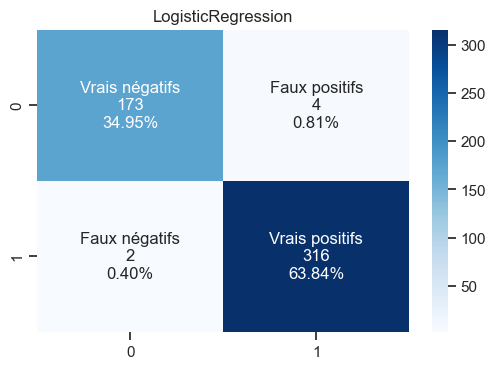

##################################################
le score de  KMeans est 0.9838


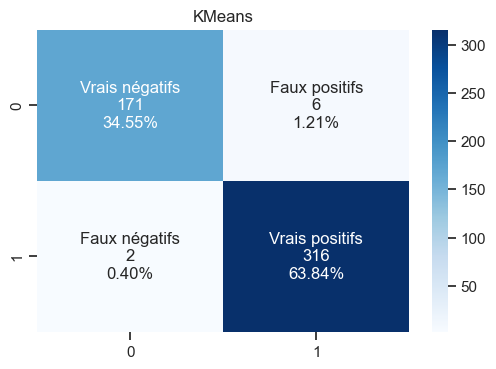

In [1229]:
prediction=Ensemble(models).matrice_confusion(resultat)
prediction 

D'aprés les resultats , nous avons choisi la regression logitique pour la prediction des billet. En effet cet alhorithme donne les meilleurs resulats sur l'echantillon testé . De maniere générale les modéles basant sur une apprentissage supervisée sont souvent plus performant et plus facile à interpreter. 

## Apprentissage du modéle choisi

Nous allons entrainer le modéle de regression de logistique et enregistrer le modéle sur un fichier pickle afin d'utiliser sur notre fonction de prediction de faux billets

In [1230]:
y=df.pop('is_genuine')
train_model(df.values,y,regression)

In [1231]:
prediction=detection_billet("billets_production.csv")
prediction

,Prédiction,Probabilité de faux,Probabilité de vrai,id
0,Faux billet,0.964244,0.035756,A_1
1,Faux billet,0.989580,0.010420,A_2
2,Faux billet,0.993823,0.006177,A_3
3,Vrai billet,0.000069,0.999931,A_4
4,Vrai billet,0.000002,0.999998,A_5
